In [1]:
import torch
import numpy as np
import pandas as pd
from glob import glob
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

from torchvision.io import read_image
from torchvision.transforms import Resize
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch import optim
import torchvision.utils as vutils

%config Completer.use_jedi = False


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
paths = glob('data/*/*/*/*.jpg')

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
adjust_image = Resize(size=(256, 512))
inverse_adjust = Resize(size=(256, 467))

torch.Size([3, 256, 467])


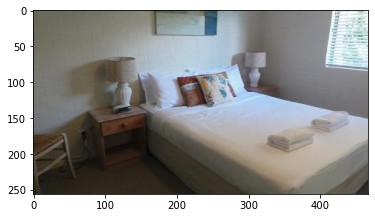

In [6]:
image = read_image(paths[0])
print(image.shape)
imshow(torch.movedim(image, 0, 2))

torch.Size([3, 256, 512])


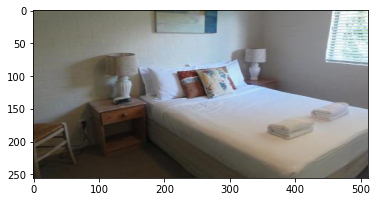

In [7]:
image = adjust_image(image)
print(image.shape)
imshow(torch.movedim(image, 0, 2))

torch.Size([3, 256, 467])


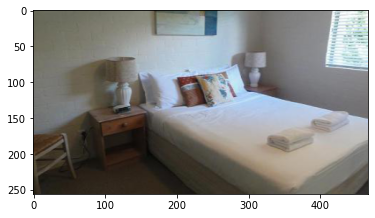

In [8]:
image = inverse_adjust(image)
print(image.shape)
imshow(torch.movedim(image, 0, 2))

In [9]:
import os
import pandas as pd
from torchvision.io import read_image

class ImageDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_path = self.paths[idx]
        image = read_image(img_path) / 256
        if self.transform:
            image = self.transform(image)
        return image

In [10]:
dataset = ImageDataset(paths, transform=adjust_image)

In [11]:
dataset[0].shape

torch.Size([3, 256, 512])

In [12]:
loader = DataLoader(dataset, batch_size=24, shuffle=True)

In [13]:
class Generator(nn.Module):
    def __init__(self, input_size=100, hidden_factor=64):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(
                input_size, hidden_factor * 16, kernel_size=(4,8), stride=1, padding=0, bias=False),
            nn.BatchNorm2d(hidden_factor * 16),
            nn.ReLU(True),

            # (hidden_factor*8) x 4 x 8
            nn.ConvTranspose2d(
                hidden_factor * 16, hidden_factor * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_factor * 8),
            nn.ReLU(True),
            
            # (hidden_factor*4) x 8 x 16
            nn.ConvTranspose2d(
                hidden_factor * 8, hidden_factor * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_factor * 4),
            nn.ReLU(True),
            
            # (hidden_factor*4) x 16 x 32
            nn.ConvTranspose2d(
                hidden_factor * 4, hidden_factor * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_factor * 4),
            nn.ReLU(True),
            
            # (hidden_factor*4) x 32 x 64
            nn.ConvTranspose2d(
                hidden_factor * 4, hidden_factor * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_factor * 2),
            nn.ReLU(True),

            # (hidden_factor*2) x 64 x 128
            nn.ConvTranspose2d(
                hidden_factor * 2, hidden_factor, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(hidden_factor),
            nn.ReLU(True),
            
            # (hidden_factor) x 128 x 256
            nn.ConvTranspose2d(
                hidden_factor, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            
#             output
#             3 x 256 x 512
        )
        
    def forward(self, x):
        return self.network(x)

# x = torch.randn(32, 100, 1, 1).to(device)
G = Generator().to(device).apply(weights_init)
# G(x).shape

In [14]:
class Discriminator(nn.Module):
    def __init__(self, hidden_factor=32):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, hidden_factor, kernel_size=5, stride=2, padding=2, bias=False),
#             nn.BatchNorm2d(hidden_factor),
            nn.LeakyReLU(0.2, inplace=True),
            # (hidden_factor) x 128 x 256
            nn.Conv2d(hidden_factor, hidden_factor * 2, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(hidden_factor * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (hidden_factor * 2) x 64 x 128
            nn.Conv2d(hidden_factor * 2, hidden_factor * 4, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(hidden_factor * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (hidden_factor * 4) x 32 x 64
            nn.Conv2d(hidden_factor * 4, hidden_factor * 8, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(hidden_factor * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # (hidden_factor * 4) x 16 x 32
            nn.Conv2d(hidden_factor * 8, hidden_factor * 16, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(hidden_factor * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # (hidden_factor * 8) x 8 x 16
            nn.Conv2d(hidden_factor * 16, hidden_factor * 32, kernel_size=5, stride=2, padding=2, bias=False),
            nn.BatchNorm2d(hidden_factor * 32),
            nn.LeakyReLU(0.2, inplace=True),
            # (hidden_factor * 8) x 4 x 8
            nn.Conv2d(hidden_factor * 32, 1, kernel_size=(4,8)),
            nn.Flatten(),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.network(x)

x = torch.randn(32, 3, 256, 512).to(device)
D = Discriminator().to(device).apply(weights_init)
D.forward(x).shape

torch.Size([32, 1])

In [15]:
criterion = nn.BCELoss()
lr = 0.0002
beta1 = 0.5

optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))

Starting Training Loop...
[0/100][0/12631]	Loss_D: 3.1754	Loss_G: 8.6174	D(x): 0.1924	D(G(z)): 0.3062 / 0.0240


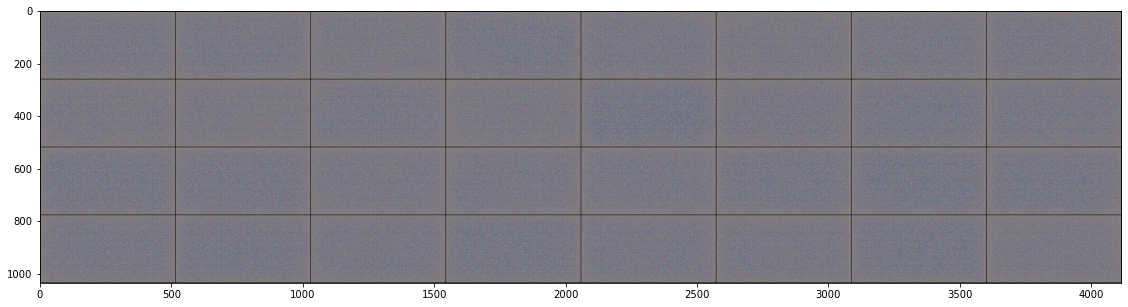

[0/100][50/12631]	Loss_D: 0.0007	Loss_G: 58.9582	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000


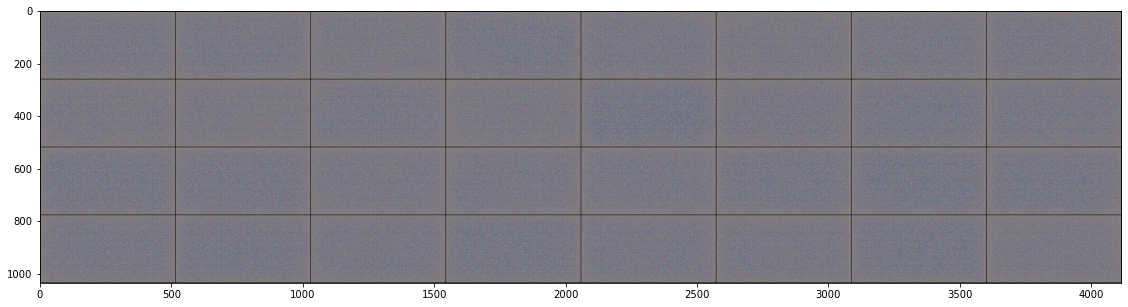

[0/100][100/12631]	Loss_D: 0.0000	Loss_G: 54.4848	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


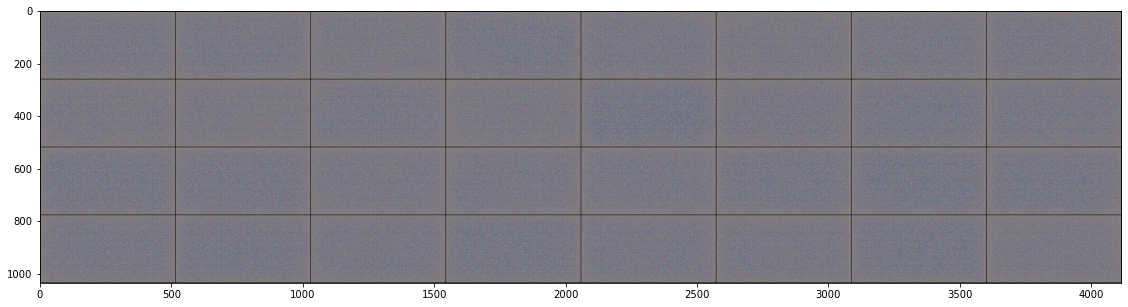

[0/100][150/12631]	Loss_D: 0.0000	Loss_G: 55.6134	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


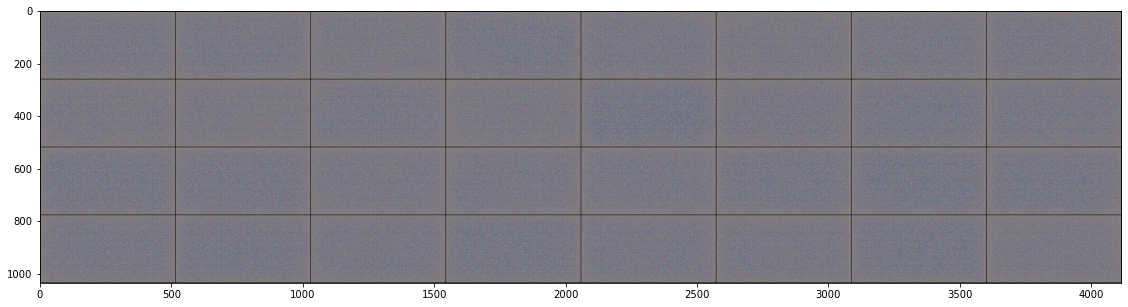

[0/100][200/12631]	Loss_D: 0.0000	Loss_G: 54.7654	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


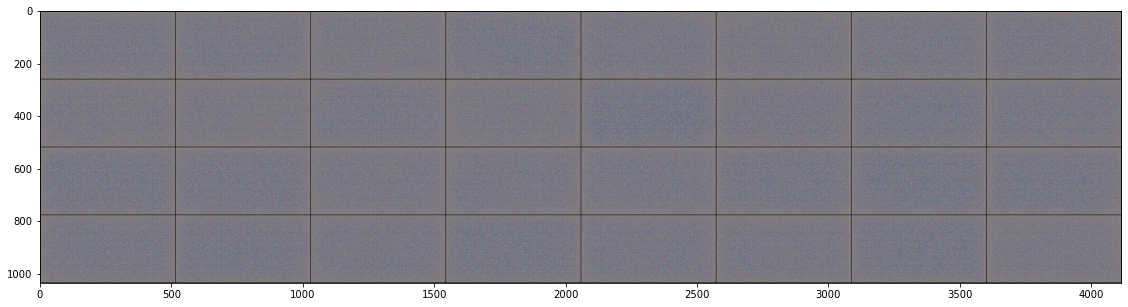

[0/100][250/12631]	Loss_D: 0.0000	Loss_G: 54.5277	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


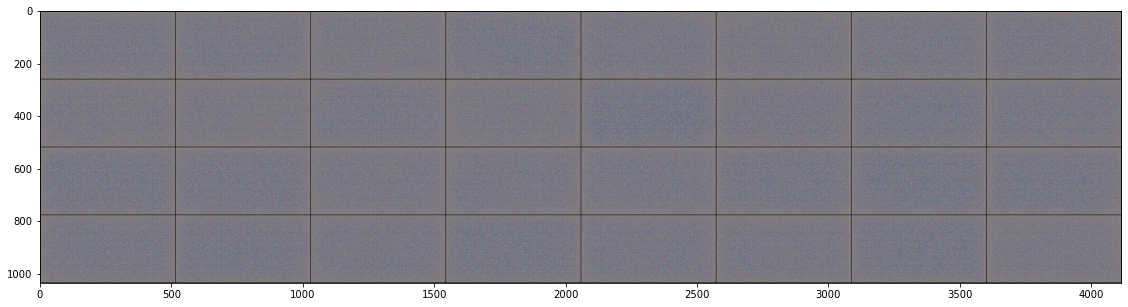

[0/100][300/12631]	Loss_D: 0.0000	Loss_G: 54.6103	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


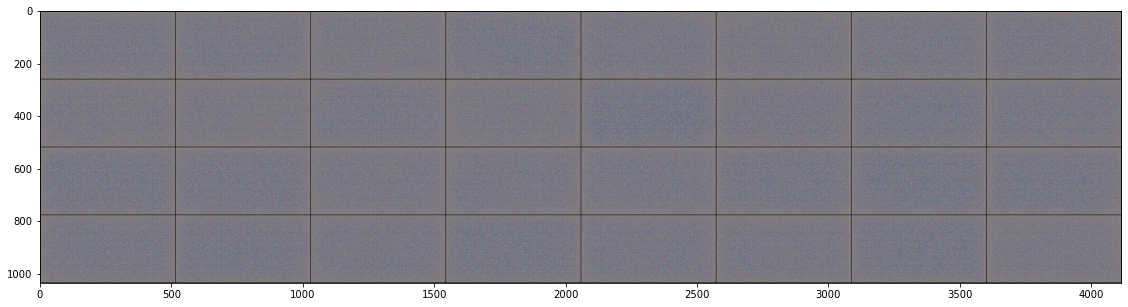

[0/100][350/12631]	Loss_D: 0.0000	Loss_G: 54.5247	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


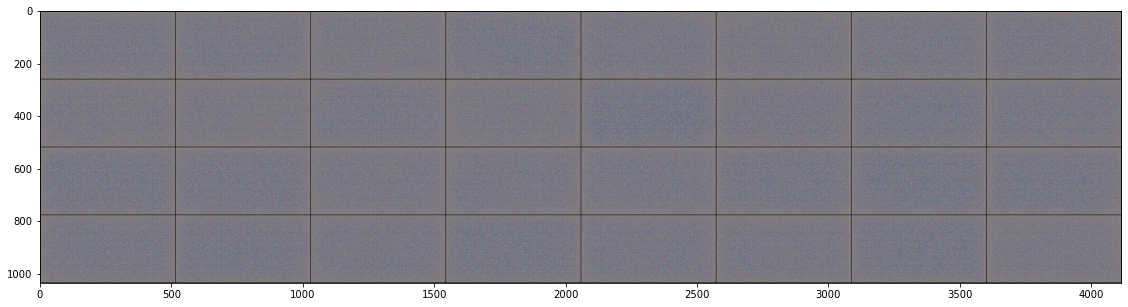

[0/100][400/12631]	Loss_D: 0.0000	Loss_G: 55.6289	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


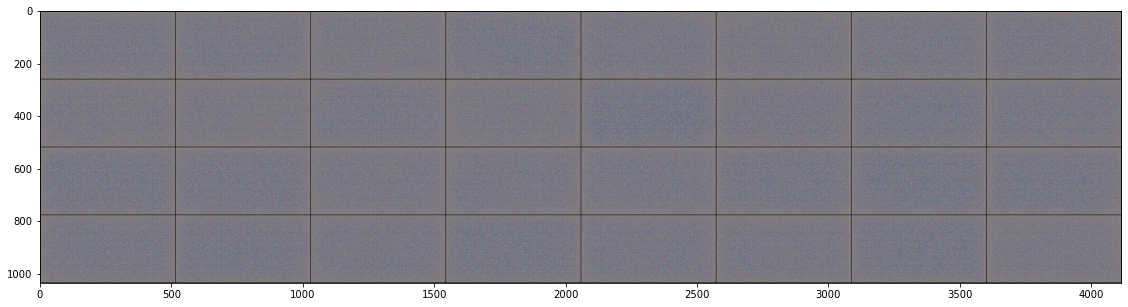

[0/100][450/12631]	Loss_D: 0.0000	Loss_G: 54.5498	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


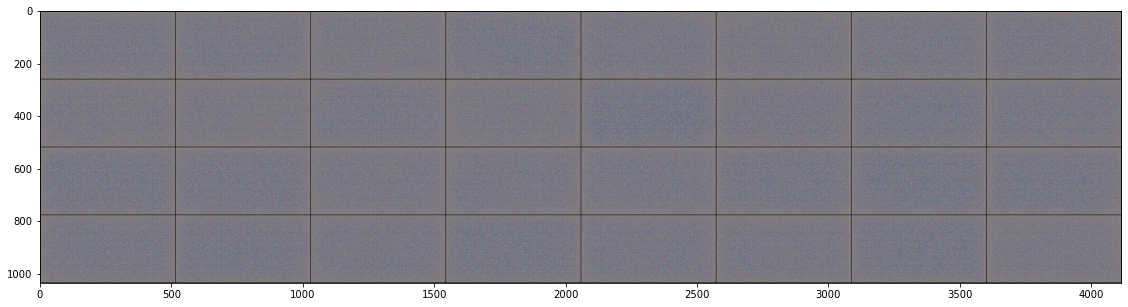

[0/100][500/12631]	Loss_D: 0.0000	Loss_G: 56.1223	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000


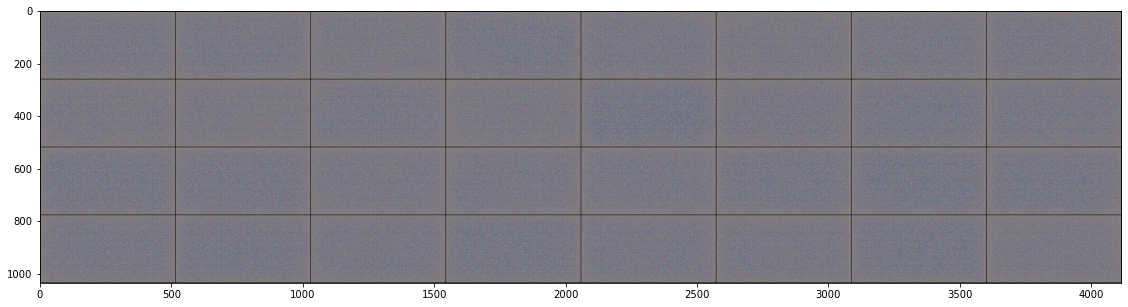

KeyboardInterrupt: 

In [16]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
num_epochs = 100
real_label = 1.
fake_label = 0.


fixed_noise = torch.randn(32, 100, 1, 1).to(device)

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(loader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        D.zero_grad()
        # Format batch
        real = data.to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        
        output = D(real).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        # Generate fake image batch with G
        fake = G(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = D(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        G.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = D(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (i % 50 == 0) or ((epoch == num_epochs-1) and (i == len(loader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            plt.figure(figsize=(20,5))
            img = img_list[0].squeeze().movedim(0,2).cpu().detach().numpy()
            fig = imshow(img)
            plt.savefig(f'fakes/{i}.png')
            plt.show()
            

